In [45]:
import os
import sys
from pathlib import Path
import pandas as pd

from arcgis.features import GeoAccessor
from arcgis.geometry import Geometry
from arcgis.gis import GIS
from ba_data_paths import ba_data

sys.path.append('../../src')
from geoai_retail import proximity_local as proximity
from geoai_retail import utils
from geoai_retail import analysis

sys.path.append('../../scripts')
import data_sources

In [2]:
data = Path(os.path.abspath('../../data'))
interim_dir = data/'interim'
raw_dir = data/'raw'
raw_gdb = raw_dir/'raw.gdb'

closest_brand = interim_dir/'closest_store.csv'
closest_comp = interim_dir/'closest_competition.csv'
origin_demographics = interim_dir/'origin_enrich_all.csv'
inrix_trips = interim_dir/'cust_count_inrix.csv'

comp_fc = raw_gdb/'sea_ace_comp'
comp_name_fld = 'CONAME'
brand_fc = raw_gdb/'sea_ace'
brand_id_fld = 'LOCNUM'
hex_fc = raw_gdb/'real_estate_hex'
hex_id_fld = 'GRIDID'

study_loc_id = 409083547
hex_ex_id = 1561

In [3]:
dest_brand_df = GeoAccessor.from_featureclass(data_sources.destination_store_locations)
dest_brand_df.drop('OBJECTID', axis=1, inplace=True)
dest_brand_df.head()

,LOCNUM,CONAME,STREET,CITY,STATE,STATE_NAME,ZIP,ZIP4,NAICS,SIC,...,ISCODE,SQFTCODE,LOC_NAME,STATUS,SCORE,SOURCE,REMOVE,NEAR_FID,NEAR_DIST,SHAPE
0,371889957,GRAHAM ACE HARDWARE,224TH ST E,GRAHAM,WA,Washington,98338,5704,44413005,525104,...,,6,PointAddress,M,100.0000,INFOGROUP,0,3,0.000021,"{""x"": -122.29909999999995, ""y"": 47.05410000000..."
1,460556608,OAKBROOK ACE HARDWARE,STEILACOOM BLVD SW,TACOMA,WA,Washington,98498,6154,44413005,525104,...,,3,StreetAddress,M,96.3594,INFOGROUP,0,35,0.000010,"{""x"": -122.54489999999998, ""y"": 47.18000000000..."
2,405129289,GIG HARBOR ACE HARDWARE,POINT FOSDICK DR NW,GIG HARBOR,WA,Washington,98335,1711,44413005,525104,...,,7,StreetAddress,M,100.0000,INFOGROUP,0,41,0.000019,"{""x"": -122.57929999999999, ""y"": 47.30130000000..."
3,216082099,SOUTH END ACE HARDWARE,PACIFIC AVE S,SPANAWAY,WA,Washington,98387,8395,44413005,525104,...,,5,PointAddress,M,100.0000,INFOGROUP,0,96,55.586255,"{""x"": -122.43459999999999, ""y"": 47.08740000000..."
4,721714069,ACE HARDWARE,112TH ST S,PARKLAND,WA,Washington,98444,5711,44413005,525104,...,,3,PointAddress,M,95.4063,INFOGROUP,0,98,0.000010,"{""x"": -122.43199999999996, ""y"": 47.15610000000..."


In [4]:
data_sources.origin_customer_areas

'D:\\projects\\geoai-retail\\data\\raw\\raw.gdb\\sea_block_group'

In [6]:
closest_sol_df = proximity.get_closest_solution(data_sources.origin_customer_areas, data_sources.origin_customer_area_id_field, 
                               data_sources.destination_store_locations, data_sources.destination_store_id_field,
                               network_dataset=ba_data.usa_network_dataset, destination_count=6)
closest_sol_df.head()

,origin_id,destination_rank,destination_id,proximity_traveltime,proximity_kilometers,SHAPE
0,530530701003,1,677129595,43.576384,38.513638,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
1,530530701003,2,371889957,46.482533,42.526899,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
2,530530701003,3,427271369,52.472263,44.462895,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
3,530530701003,4,421027779,55.156955,44.748810,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
4,530530701003,5,721714069,61.428125,50.456415,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."


In [28]:
closest_sol_df.spatial.to_featureclass(str(interim_dir/'interim.gdb'/'closest_solution'))

'D:\\projects\\geoai-retail\\data\\interim\\interim.gdb\\closest_solution'

In [35]:
origin_df = GeoAccessor.from_featureclass(str(data_sources.origin_customer_areas))
origin_df[data_sources.origin_customer_area_id_field] = origin_df[data_sources.origin_customer_area_id_field].astype(str)
origin_df.set_index(data_sources.origin_customer_area_id_field, inplace=True, drop=True)
origin_df.drop(['OBJECTID', 'NAME'], inplace=True, axis=1)
origin_df.head()

,SHAPE
ID,
530530701003,"{""rings"": [[[-122.06627999999995, 47.076520000..."
530530714071,"{""rings"": [[[-122.34031999999996, 47.071510000..."
530530714072,"{""rings"": [[[-122.35767999999996, 47.067370000..."
530530714073,"{""rings"": [[[-122.36847999999998, 47.067630000..."
530530714112,"{""rings"": [[[-122.41108999999994, 47.071690000..."


In [8]:
origin_closest_df = closest_sol_df.drop('SHAPE', axis=1).join(origin_df, on='origin_id')
origin_closest_df.head()

,origin_id,destination_rank,destination_id,proximity_traveltime,proximity_kilometers,SHAPE
0,530530701003,1,677129595,43.576384,38.513638,"{'rings': [[[-122.06627999999995, 47.076520000..."
1,530530701003,2,371889957,46.482533,42.526899,"{'rings': [[[-122.06627999999995, 47.076520000..."
2,530530701003,3,427271369,52.472263,44.462895,"{'rings': [[[-122.06627999999995, 47.076520000..."
3,530530701003,4,421027779,55.156955,44.748810,"{'rings': [[[-122.06627999999995, 47.076520000..."
4,530530701003,5,721714069,61.428125,50.456415,"{'rings': [[[-122.06627999999995, 47.076520000..."


In [44]:
origin_closest_df.spatial.to_featureclass(str(interim_dir/'interim.gdb'/'closest_origin_solution'))

'D:\\projects\\geoai-retail\\data\\interim\\interim.gdb\\closest_origin_solution'

In [9]:
closest_sol_comp_df = proximity.get_closest_solution(data_sources.origin_customer_areas, 
                                                     data_sources.origin_customer_area_id_field, 
                                                     data_sources.destination_competition_locations, 
                                                     data_sources.destination_competition_id_field,
                                                     network_dataset=ba_data.usa_network_dataset, 
                                                     destination_count=6)
closest_sol_comp_df.head()

,origin_id,destination_rank,destination_id,proximity_traveltime,proximity_kilometers,SHAPE
0,530530701003,1,388273260,27.324552,24.844065,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
1,530530701003,2,174262691,26.486351,25.466621,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
2,530530701003,3,679623777,30.496295,25.960217,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
3,530530701003,4,403218374,30.669763,26.656119,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
4,530530701003,5,948351200,33.274677,31.095850,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."


In [47]:
closest_sol_comp_df.spatial.to_featureclass(str(interim_dir/'interim.gdb'/'closest_origin_competition_solution'))

'D:\\projects\\geoai-retail\\data\\interim\\interim.gdb\\closest_origin_competition_solution'

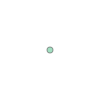

In [21]:
hex_df = GeoAccessor.from_featureclass(str(hex_fc)).set_index('OBJECTID')
hex_geom = hex_df[hex_df['GRID_ID']==str(hex_ex_id)].iloc[0].SHAPE
new_geom = Geometry({'x': hex_geom.centroid[0], 'y': hex_geom.centroid[1], 'spatialReference': {'wkid': 4326}})
new_geom

In [26]:
ent_gis = GIS('https://geoai-webgis-ent.bd.esri.com/portal', username='jmccune')
ent_gis

Enter password:  ········


GIS @ https://geoai-webgis-ent.bd.esri.com/portal version:7.1

In [36]:
origin_df.reset_index(inplace=True)

In [42]:
brand_df = GeoAccessor.from_featureclass(str(brand_fc)).set_index('OBJECTID')
brand_df.head()

,LOCNUM,CONAME,STREET,CITY,STATE,STATE_NAME,ZIP,ZIP4,NAICS,SIC,...,ISCODE,SQFTCODE,LOC_NAME,STATUS,SCORE,SOURCE,REMOVE,NEAR_FID,NEAR_DIST,SHAPE
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,371889957,GRAHAM ACE HARDWARE,224TH ST E,GRAHAM,WA,Washington,98338,5704,44413005,525104,...,,6,PointAddress,M,100.0000,INFOGROUP,0,3,0.000021,"{""x"": -122.29909999999995, ""y"": 47.05410000000..."
2,460556608,OAKBROOK ACE HARDWARE,STEILACOOM BLVD SW,TACOMA,WA,Washington,98498,6154,44413005,525104,...,,3,StreetAddress,M,96.3594,INFOGROUP,0,35,0.000010,"{""x"": -122.54489999999998, ""y"": 47.18000000000..."
3,405129289,GIG HARBOR ACE HARDWARE,POINT FOSDICK DR NW,GIG HARBOR,WA,Washington,98335,1711,44413005,525104,...,,7,StreetAddress,M,100.0000,INFOGROUP,0,41,0.000019,"{""x"": -122.57929999999999, ""y"": 47.30130000000..."
4,216082099,SOUTH END ACE HARDWARE,PACIFIC AVE S,SPANAWAY,WA,Washington,98387,8395,44413005,525104,...,,5,PointAddress,M,100.0000,INFOGROUP,0,96,55.586255,"{""x"": -122.43459999999999, ""y"": 47.08740000000..."
5,721714069,ACE HARDWARE,112TH ST S,PARKLAND,WA,Washington,98444,5711,44413005,525104,...,,3,PointAddress,M,95.4063,INFOGROUP,0,98,0.000010,"{""x"": -122.43199999999996, ""y"": 47.15610000000..."


In [59]:
from geoai_retail.utils import get_dataframe
from geoai_retail.analysis import _get_min_uid

origins = origin_df
origin_id_field = 'ID'
destinations = brand_df
destination_id_field = brand_id_fld
closest_table = closest_brand
new_destination = new_geom
origin_weighting_points = None

# read in the existing closest table solution
closest_orig_df = pd.read_csv(closest_table)

# get a list of the destination columns from the existing closest table
dest_cols = [col for col in closest_orig_df.columns if col.startswith('destination_id')]

# get a count of the nth number of locations solved for
dest_count = len(dest_cols)

# load the original origins into a dataframe and format it for analysis
origin_df = get_dataframe(origins)
origin_df = proximity.prep_sdf_for_nearest(origin_df, origin_id_field, origin_weighting_points)

origin_df.head()

,ID,Name,SHAPE
0,530530701003,530530701003,"{""x"": -122.06419363052503, ""y"": 46.98102464761..."
1,530530714071,530530714071,"{""x"": -122.33755347415877, ""y"": 47.06002572400..."
2,530530714072,530530714072,"{""x"": -122.36110767780167, ""y"": 47.05975200787..."
3,530530714073,530530714073,"{""x"": -122.37372409228104, ""y"": 47.06006130580..."
4,530530714112,530530714112,"{""x"": -122.40627944949227, ""y"": 47.06438624199..."


In [60]:
# load the original destinations into a dataframe and format it for analysis
dest_df = get_dataframe(destinations)
dest_df = proximity.prep_sdf_for_nearest(dest_df, destination_id_field)

dest_df.head()

,ID,Name,SHAPE
OBJECTID,,,
1,371889957,371889957,"{""x"": -122.29909999999995, ""y"": 47.05410000000..."
2,460556608,460556608,"{""x"": -122.54489999999998, ""y"": 47.18000000000..."
3,405129289,405129289,"{""x"": -122.57929999999999, ""y"": 47.30130000000..."
4,216082099,216082099,"{""x"": -122.43459999999999, ""y"": 47.08740000000..."
5,721714069,721714069,"{""x"": -122.43199999999996, ""y"": 47.15610000000..."


In [61]:
# create new destination dataframe for analysis
new_id = _get_min_uid(origin_df, 'ID')  # creates lowest numbered id available, or 1000 higher than top value
new_df = pd.DataFrame([[new_id, new_id, new_destination]], columns=['ID', 'Name', 'SHAPE'])
new_df.spatial.set_geometry('SHAPE')

new_df.head()

,ID,Name,SHAPE
0,1,1,"{""x"": -122.10097367549997, ""y"": 47.31138210088..."


In [63]:
# get the nth closest destination locations to the new destination location
closest_dest_df = proximity.get_closest_solution(new_df, 'ID', dest_df, 'ID',
                                                 network_dataset=ba_data.usa_network_dataset,
                                                 destination_count=dest_count)
closest_dest_df

,origin_id,destination_rank,destination_id,proximity_traveltime,proximity_kilometers,SHAPE
0,1,1,427271369,17.027136,12.025255,"{""hasM"": true, ""paths"": [[[-122.10077472899997..."
1,1,2,409083547,23.700085,18.572272,"{""hasM"": true, ""paths"": [[[-122.10077472899997..."
2,1,3,546578055,22.415825,19.223247,"{""hasM"": true, ""paths"": [[[-122.10077472899997..."
3,1,4,688834225,22.875530,22.814336,"{""hasM"": true, ""paths"": [[[-122.10077472899997..."
4,1,5,700121193,34.597561,26.878571,"{""hasM"": true, ""paths"": [[[-122.10077472899997..."
5,1,6,677129595,32.332925,29.846394,"{""hasM"": true, ""paths"": [[[-122.10077472899997..."


In [64]:
# get the destination ids of the existing nth closest destinations
dest_subset_ids = closest_dest_df['destination_id'].values

# by cross referencing from the destination ids, get the origin ids allocated to the exiting locations
subset_origin_ids = pd.concat([closest_orig_df[closest_orig_df[dest_col].isin(dest_subset_ids)]['origin_id']
                               for dest_col in dest_cols]).unique()

# get a subset dataframe of the origins allocated to the closest nth locations
subset_origin_df = origin_df[origin_df['ID'].astype('int64').isin(subset_origin_ids)].copy()

# add the new location to the destination dataframe
dest_analysis_df = pd.concat([dest_df, new_df], sort=False)
dest_analysis_df.spatial.set_geometry('SHAPE')
dest_analysis_df.reset_index(inplace=True, drop=True)

In [65]:
closest_dest_df_fnl = proximity.get_closest_solution(subset_origin_df, 'ID', dest_analysis_df, 'ID',
                                                     network_dataset=ba_data.usa_network_dataset,
                                                     destination_count=dest_count)
closest_dest_df_fnl.spatial.plot()

MapView(layout=Layout(height='400px', width='100%'))

In [66]:
closest_dest_df_fnl.head()

,origin_id,destination_rank,destination_id,proximity_traveltime,proximity_kilometers,SHAPE
0,530530701003,1,677129595,43.576384,38.513638,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
1,530530701003,2,371889957,46.482533,42.526899,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
2,530530701003,3,1,43.183005,43.258197,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
3,530530701003,4,427271369,52.472263,44.462895,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."
4,530530701003,5,421027779,55.156955,44.748810,"{""hasM"": true, ""paths"": [[[-122.03589, 47.0116..."


In [70]:
closest_dest_df_ex = closest_dest_df_fnl[closest_dest_df_fnl['origin_id'] == '530330320063'].copy()
closest_dest_df_ex.spatial.plot()

MapView(layout=Layout(height='400px', width='100%'))

In [71]:
closest_dest_df_ex.spatial.to_featureclass(str(interim_dir/'interim.gdb/route_example'))

'D:\\projects\\geoai-retail\\data\\interim\\interim.gdb\\route_example'